# PGACOACH XGBOOST PROJECT

In [58]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [59]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.impute import KNNImputer
import itertools


## 1. Loading and prepping data

In [60]:
#load and prep data
df = pd.read_excel("pgatour_players_stats.xlsx")
df.head()

,Player ID,Player,Profile URL,Stats Page URL,SG: Total - Primary,SG: Total - Rank,SG: Tee-to-Green - Primary,SG: Tee-to-Green - Rank,SG: Off-the-Tee - Primary,SG: Off-the-Tee - Rank,...,Consecutive Holes Below Par - Primary,Consecutive Holes Below Par - Rank,Consecutive Birdies Streak - Primary,Consecutive Birdies Streak - Rank,Consecutive Birdies/Eagles streak - Primary,Consecutive Birdies/Eagles streak - Rank,Official Money - Primary,Official Money - Rank,Comcast Business TOUR TOP 10 - Primary,Comcast Business TOUR TOP 10 - Rank
0,28237,Rory Mcilroy,https://www.pgatour.com/player/28237/rory-mcilroy,https://www.pgatour.com/player/28237/rory-mcil...,2.319,1,1.725,2,0.857,1,...,4,37,4,31,3,17,"$9,057,558",1,1683,1
1,50525,Collin Morikawa,https://www.pgatour.com/player/50525/collin-mo...,https://www.pgatour.com/player/50525/collin-mo...,2.18,2,1.999,1,0.54,15,...,5,10,5,9,3,17,"$5,558,964",3,1081,4
2,46046,Scottie Scheffler,https://www.pgatour.com/player/46046/scottie-s...,https://www.pgatour.com/player/46046/scottie-s...,2.001,3,1.681,3,0.618,7,...,4,37,4,31,1,137,"$3,341,197",10,928,10
3,30911,Tommy Fleetwood,https://www.pgatour.com/player/30911/tommy-fle...,https://www.pgatour.com/player/30911/tommy-fle...,1.562,4,1.224,8,0.41,27,...,4,37,4,31,-,-,"$1,893,098",27,534,28
4,33204,Shane Lowry,https://www.pgatour.com/player/33204/shane-lowry,https://www.pgatour.com/player/33204/shane-low...,1.555,5,1.453,4,0.245,45,...,4,37,4,31,3,17,"$3,613,011",8,829,13


In [61]:
player_names = df["Player"]

In [62]:
# Drop leakage columns
X = df.drop(
    [c for c in df.columns
     if ("Rank" in c)
     or ("Scoring Average" in c)
     or ("Lowest Round" in c)
     or ("Final Round Performance" in c)
     or ("Comcast Business TOUR TOP 10" in c)
     or ("Official Money" in c)
     or ("SG: Total" in c)
     or ("Par Breakers" in c)
     or (c in ["Player ID","Player","Profile URL","Stats Page URL"])],
    axis=1
)

In [63]:
# Define target
y = df["Scoring Average (Adjusted) - Primary"].astype(str).replace('-', 'NaN')
y = pd.to_numeric(y, errors='coerce')

In [64]:
# Clean X columns
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = (X[col]
                  .astype(str)
                  .str.replace('$','')
                  .str.replace(',','')
                  .replace('-', 'NaN'))
        X[col] = pd.to_numeric(X[col], errors='coerce')

/var/folders/7d/w2yczwmx18v884x1h1yk0qdc0000gn/T/ipykernel_12019/1762085457.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('$','')


In [65]:
# Filter valid rows
valid = y.notna()
X = X[valid]
y = y[valid].astype('float32')

player_names_valid = player_names[valid].reset_index(drop=True)


In [66]:
# Sanitize names
new_cols = []
for col in X.columns:
    new_cols.append(col.replace('[','').replace(']','')
                        .replace('<','lt').replace('>','gt')
                        .replace(',','').replace('(','').replace(')',''))
X.columns = new_cols


In [67]:

# Drop fully NaN columns
X = X.dropna(axis=1, how='all')

# KNN imputation
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# Rebuild DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)
X = X.astype('float32')

In [68]:
# 2. Baseline train/test split & model to get gain importances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_model = XGBRegressor(
    n_estimators=200, 
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8, 
    colsample_bytree=0.8,
    random_state=42, 
    early_stopping_rounds=10
)

base_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Extract gain importances
booster = base_model.get_booster()
gain_dict = booster.get_score(importance_type='gain')
gain_series = pd.Series(gain_dict).sort_values(ascending=False)

## 2. Model running to find best features utilizing gain

In [69]:
# 3–5. Find optimal number of top-gain features by scanning N=1..min(50, total features)
max_features = min(50, len(gain_series))
results = []
for N in range(1, max_features + 1):
    features_N = gain_series.head(N).index.tolist()
    # Split data
    X_N = X[features_N]
    X_tr, X_te, y_tr, y_te = train_test_split(X_N, y, test_size=0.2, random_state=42)
    # Train model
    model_N = XGBRegressor(
        n_estimators=200, 
        max_depth=3, 
        learning_rate=0.1,
        subsample=0.8, 
        colsample_bytree=0.8,
        random_state=42, 
        early_stopping_rounds=10
    )
    model_N.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False)
    # Evaluate RMSE
    y_pred = model_N.predict(X_te)
    rmse = mean_squared_error(y_te, y_pred) ** 0.5
    results.append((N, rmse))


In [70]:
# Identify best N
best_N, best_rmse = min(results, key=lambda x: x[1])
print(f"Best feature count: {best_N} with Test RMSE: {best_rmse:.4f}")

# List the features for best N
best_features = gain_series.head(best_N).index.tolist()
print("Features for best N (feature: gain):")
for feat in best_features:
    print(f"- {feat}")

Best feature count: 48 with Test RMSE: 0.5071
Features for best N (feature: gain):
- SG: Tee-to-Green - Primary
- Bogey Avoidance - Primary
- YTD Par or Better Streak - Primary
- Birdie Average - Primary
- Going for the Green - Primary
- Par 4 Birdie or Better Leaders - Primary
- Consecutive Fairways Hit - Primary
- Scrambling - Primary
- Best YTD Streak w/o a 3-Putt - Primary
- Total Hole Outs - Primary
- Par 5 Birdie or Better Leaders - Primary
- Putting - Inside 10' - Primary
- Putts per Round - Round 1 - Primary
- Birdie or Better Conversion Percentage - Primary
- Consecutive Birdies Streak - Primary
- SG: Approach the Green - Primary
- Going for the Green - Hit Green Pct. - Primary
- Driving Distance - Primary
- Putting from 3' - Primary
- Longest Drives - Primary
- SG: Putting - Primary
- Birdie or Better Percentage - Primary
- Putting from - gt 25' - Primary
- Putting from - 20-25' - Primary
- Putting Average - Primary
- 3-Putt Avoidance - Primary
- Putting from 9' - Primary
- S

## 3. SHAP analysis

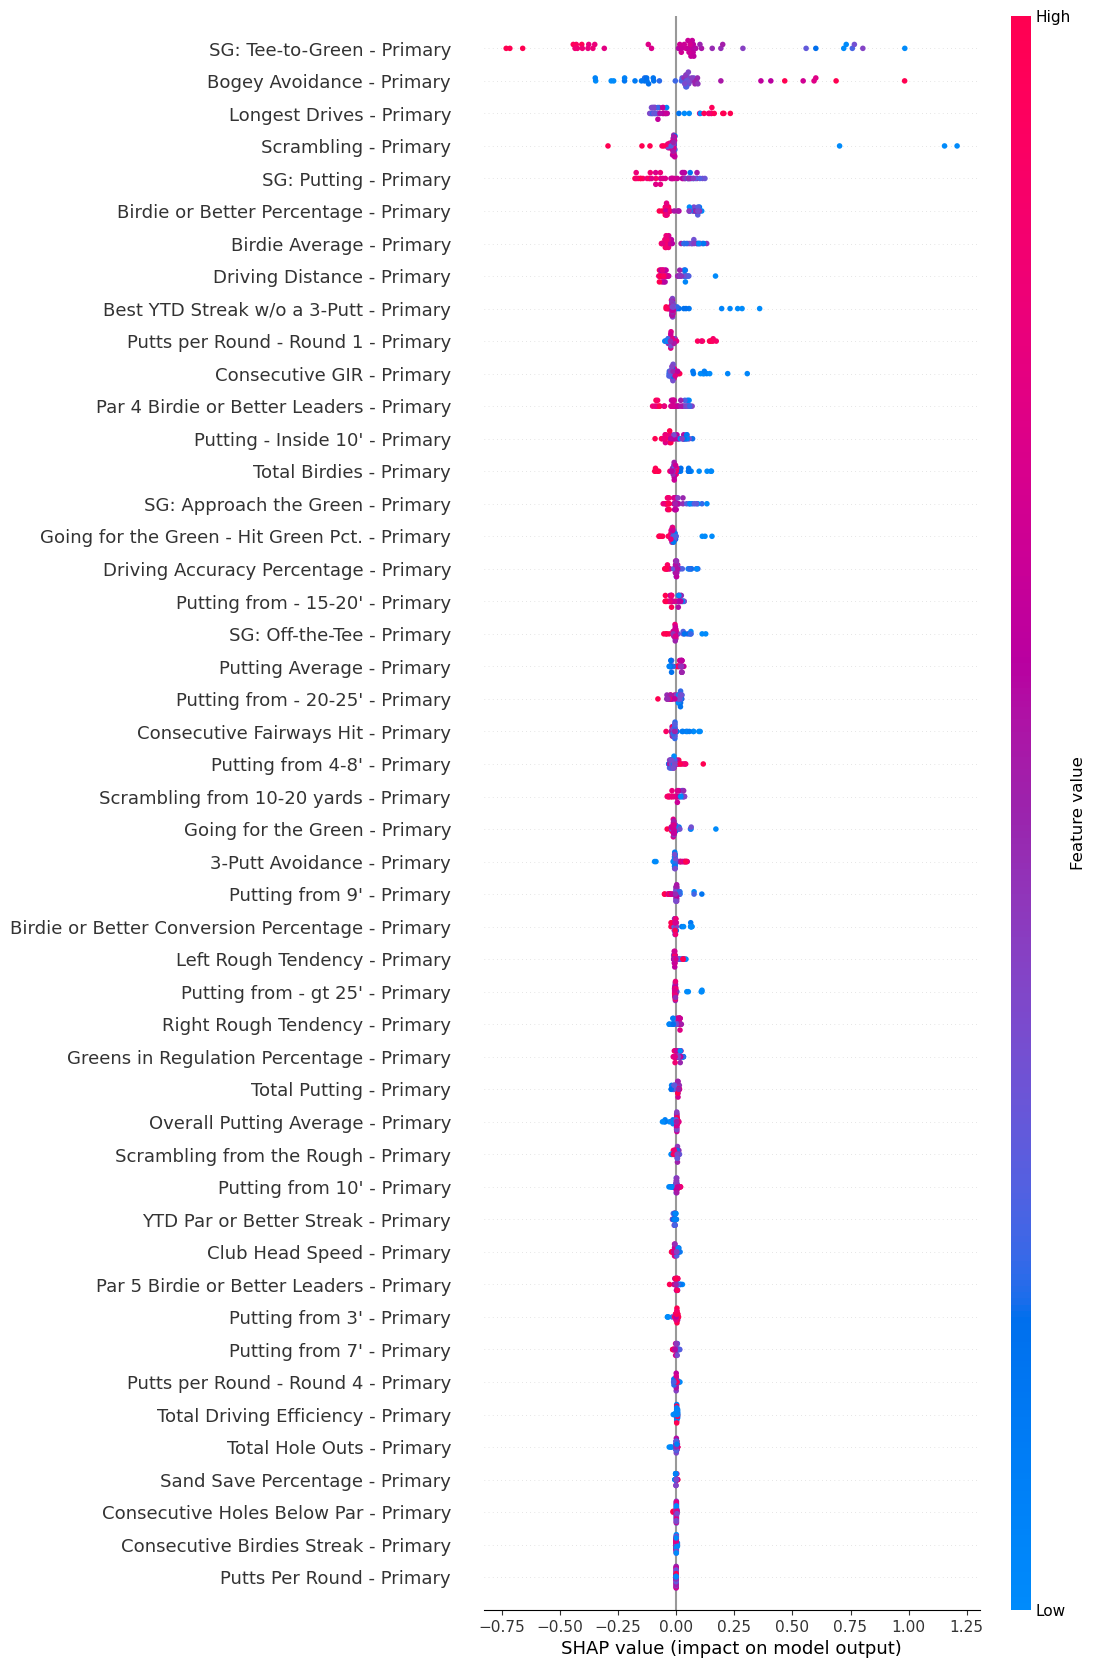

/var/folders/7d/w2yczwmx18v884x1h1yk0qdc0000gn/T/ipykernel_12019/633666145.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_best, plot_type="bar", max_display=len(best_features))


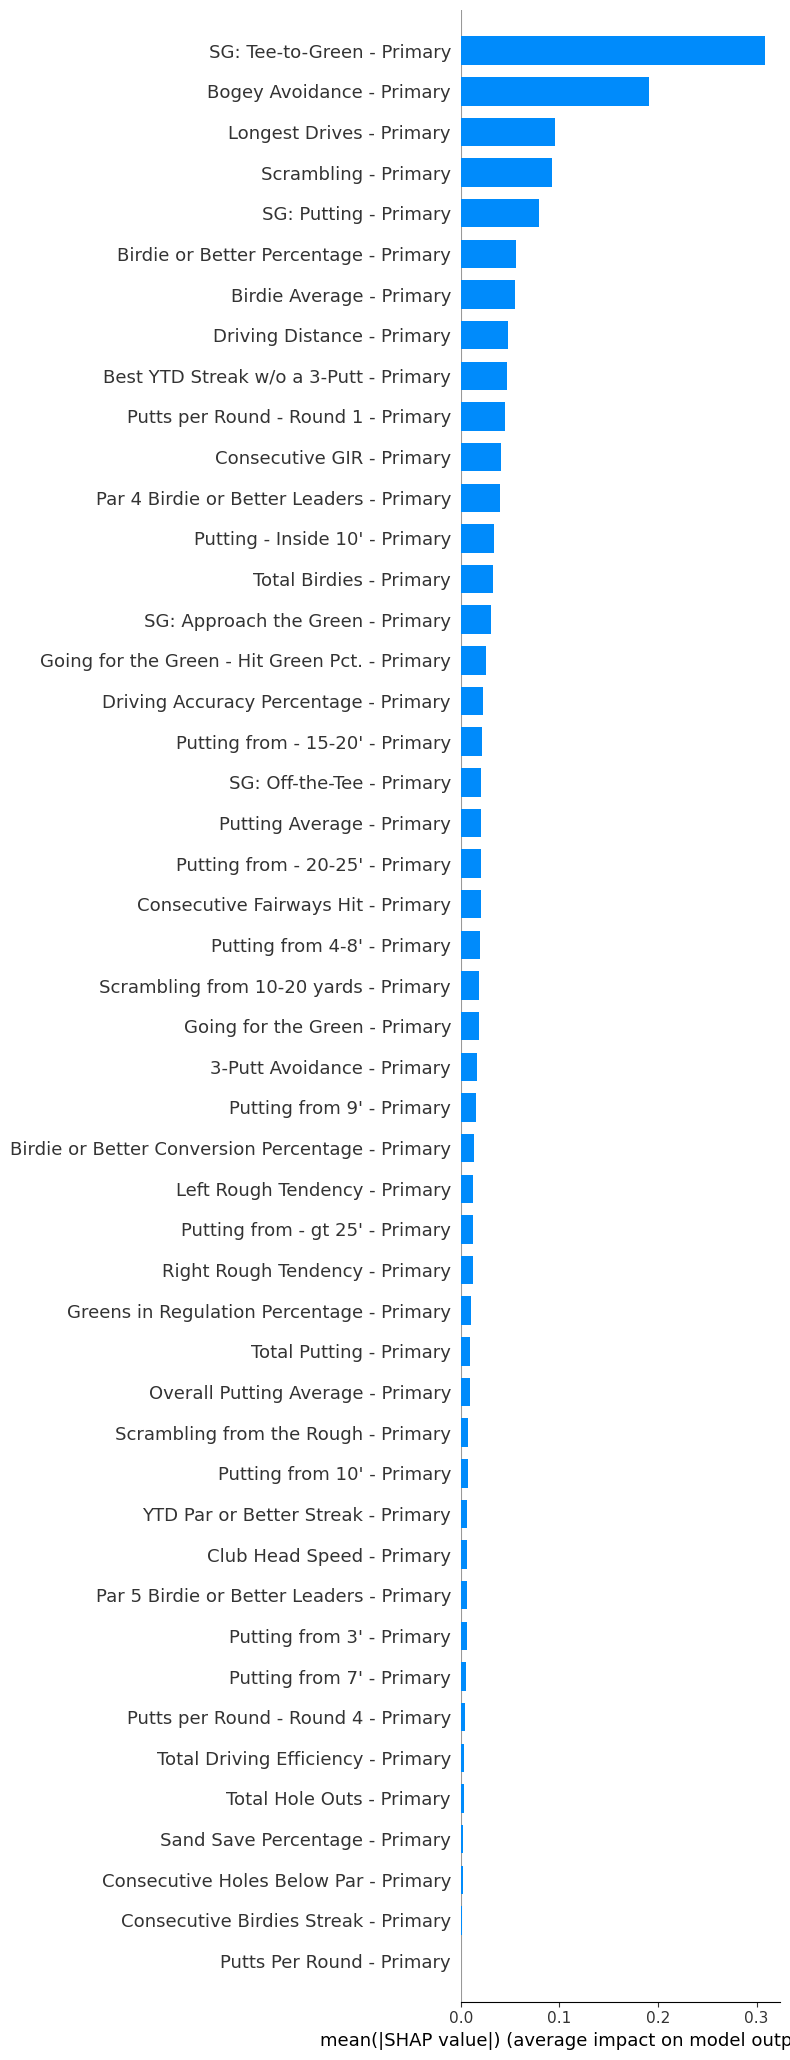

In [71]:
# 2. Subset your train/test splits to just those columns
X_train_best = X_train[best_features]
X_test_best  = X_test[best_features]

# 3. Retrain a fresh XGBoost on only the best features
model_best = XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10
)
model_best.fit(
    X_train_best, y_train,
    eval_set=[(X_test_best, y_test)],
    verbose=False
)

# 4. Create a SHAP explainer and compute values
explainer = shap.Explainer(model_best, X_train_best)
shap_values = explainer(X_test_best)

# 5a. Global importance (beeswarm)
shap.plots.beeswarm(shap_values, max_display=len(best_features))

# 5b. Summary bar plot (optional)
shap.summary_plot(shap_values, X_test_best, plot_type="bar", max_display=len(best_features))

## PDP displays

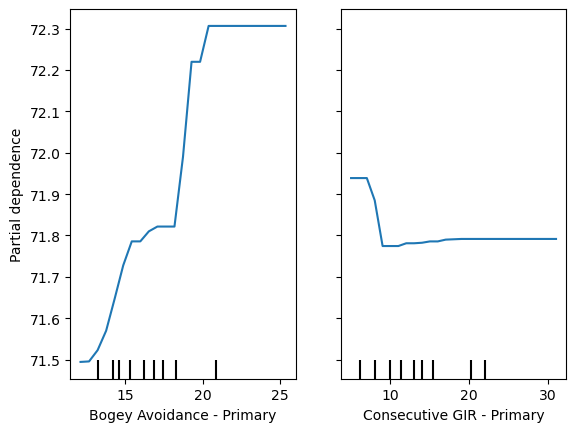

In [72]:
features_for_pdp = [feat for feat in ["Bogey Avoidance - Primary", "Consecutive GIR - Primary"]
                    if feat in X_test_best.columns]

if features_for_pdp:
    PartialDependenceDisplay.from_estimator(
        model_best, X_test_best, features_for_pdp, kind="average", grid_resolution=25
    )


## Cross-Validation

In [73]:
best_features = gain_series.head(best_N).index.tolist()

X_cv = X[best_features]
y_cv = y

#dmatrix for xgboost
dtrain = xgb.DMatrix(data=X_cv, label=y_cv)

best_rmse = 999999999999
best_params = None

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.3]
}

all_combos = list(itertools.product(
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['min_child_weight'],
    param_grid['gamma']
))

print(f"Testing {len(all_combos)} parameter combinations...")

for combo in all_combos:
    max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma = combo

    params = {
        'objective': 'reg:squarederror',
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'seed': 42
    }

    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        nfold=5,
        early_stopping_rounds=10,
        metrics="rmse",
        seed=42,
        verbose_eval=False
    )

    mean_rmse = cv_results["test-rmse-mean"].iloc[-1]

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params
        print(f"New best RMSE: {best_rmse:.4f}")
        print("Params:", best_params)

print("==== FINAL BEST RESULT ====")
print(f"Lowest RMSE: {best_rmse:.4f}")
print("Best parameters:")
print(best_params)

Testing 729 parameter combinations...
New best RMSE: 0.6675
Params: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'gamma': 0, 'seed': 42}
New best RMSE: 0.6651
Params: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'gamma': 0.1, 'seed': 42}
New best RMSE: 0.6642
Params: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'gamma': 0.3, 'seed': 42}
New best RMSE: 0.6602
Params: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0, 'seed': 42}
New best RMSE: 0.6599
Params: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0.1, 'se

In [75]:
best_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=cv_results.shape[0]
)

y_pred = best_model.predict(dtrain)

results_df = pd.DataFrame({
    "Player": player_names_valid,
    "Predicted_Scoring_Average": y_pred,
    "Actual_Scoring_Average": y_cv.values
})

# Calculate prediction error
results_df["Prediction_Error"] = results_df["Predicted_Scoring_Average"] - results_df["Actual_Scoring_Average"]


results_df

,Player,Predicted_Scoring_Average,Actual_Scoring_Average,Prediction_Error
0,Rory Mcilroy,69.792046,69.280998,0.511047
1,Collin Morikawa,70.192169,70.018997,0.173172
2,Scottie Scheffler,70.010742,69.499001,0.511742
3,Tommy Fleetwood,70.486649,70.237000,0.249649
4,Shane Lowry,70.334015,70.188004,0.146011
...,...,...,...,...
228,Troy Merritt,73.357727,73.039001,0.318726
229,Tiger Woods,73.687027,73.476997,0.210030
230,Chez Reavie,72.706406,72.873001,-0.166595
231,Kevin Tway,72.587326,72.439003,0.148323
